In [3]:
import pickle
import os
import sys
import glob
import numpy as np
import librosa
import librosa.display
import yaml

import matplotlib.pyplot as plt

In [4]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [5]:
plt.style.use('seaborn-poster')

In [6]:
from baseline import *

Using TensorFlow backend.


In [7]:
FOLDER_ROOT = '../../'
DATA_FOLDER_RAW = 'raw'
#DATA_FOLDER_MONO = 'mono'
NOISE_L1_FN = 'noise_level_1_m6dB'
NOISE_L2_FN = 'noise_level_2_p0dB'
NOISE_L3_FN= 'noise_level_3_p6dB'
DEVICE_FNS = ['fan', 'valve', 'pump', 'slider']
DEVICE_ID_FNS = ['id_00', 'id_02', 'id_04', 'id_06']
DEVICE_COND_FNS = ['normal', 'abnormal']
LOGFILE = 'baseline.log'
CMAP = librosa.display.cmap([-80, 0, 80], cmap_seq='magma', cmap_bool='gray_r', cmap_div='magma') #colormap
SR = 16e3 #sample_rate

In [8]:
# load parameter yaml
with open(FOLDER_ROOT + "setup_macro.yml") as stream:
        param = yaml.safe_load(stream)

# make output directory
os.makedirs(param["pickle_directory"], exist_ok=True)

# load base_directory list
dirs = sorted(glob.glob(os.path.abspath( \
    "{base}/*/*/*".format(base=param["base_directory"].replace('./',FOLDER_ROOT))
    )))
dirs

['E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\pump\\id_00',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\pump\\id_02',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\pump\\id_04',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\pump\\id_06',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\6dB\\pump\\id_00',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\6dB\\pump\\id_02',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\6dB\\pump\\id_04',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\6dB\\pump\\id_06',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\min6dB\\pump\\id_00',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\min6dB\\pump\\id_02',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\min6dB\\pump\\id_04',
 'E:\\Capstone\\project\\NF_Prj_MIMII_Dataset\\dataset\\min6dB\\pump\\id_06']

# Data Exploration

sr: sampling rate
frame = short audio clip
n_fft = samples per frame
hop_length = #samples between frames

```python
y, sr = librosa.load( file )
Audio(data=y, rate)
librosa.display.waveplot(y, sr)
librosa.stft(y) #short time fourier transform
```

In [9]:
def get_files(target_dir, operation='normal', file_idx=0, sr=16e3):

    # dataset param
    db = os.path.split(os.path.split(os.path.split(target_dir)[0])[0])[1]
    machine_type = os.path.split(os.path.split(target_dir)[0])[1]
    machine_id = os.path.split(target_dir)[1]

    files_path = target_dir + '\\' + operation + '\\'
    file_path = files_path + os.listdir(files_path)[file_idx]
    y, _ = librosa.load(file_path,sr=sr , mono=True)
    return y

In [10]:
# import Audio playback widget
import IPython
from IPython.display import Audio

def comp_audio(target_dir, file_idx=0):
    
    y_norm = get_files(target_dir, file_idx=file_idx)
    y_anorm = get_files(target_dir, file_idx=file_idx, operation='abnormal')
    
    IPython.display.display(Audio(data=y_norm, rate=SR))
    IPython.display.display(Audio(data=y_anorm, rate=SR))

In [11]:
comp_audio(dirs[0])

In [12]:
from librosa.display import waveplot

def comp_waveplot(target_dir, file_idx=0, sr=16e3):
    
    y_norm = get_files(target_dir, file_idx=file_idx)
    y_anorm = get_files(target_dir, file_idx=file_idx, operation='abnormal')
    
    print(type(y_norm))
    
    plt.subplot(1, 2, 1)
    waveplot(y_norm)
    
    plt.subplot(1, 2, 2)
    waveplot(y_anorm)

<class 'numpy.ndarray'>


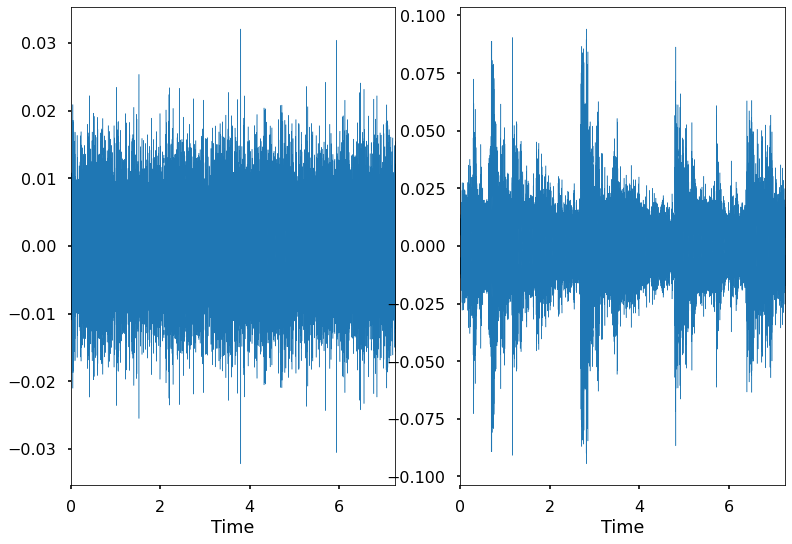

In [13]:
comp_waveplot(dirs[0])

## Short time Fourier transform (STFT)

In [26]:
from librosa.display import specshow

def comp_stft(target_dir, file_idx=0):
    # Compare short time Fourier transform
    
    # get data
    y_norm = get_files(target_dir, file_idx=file_idx)
    y_anorm = get_files(target_dir, file_idx=file_idx, operation='abnormal')
    
    D_norm = librosa.stft(y_norm)
    D_anorm = librosa.stft(y_anorm)
    
    plt.subplot(1, 2, 1)
    ax1 = specshow(librosa.amplitude_to_db(np.abs(D_norm), ref=np.max)
                   , cmap=CMAP)
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    ax2 = specshow(librosa.amplitude_to_db(np.abs(D_anorm), ref=np.max)
                   , cmap=CMAP)
    plt.colorbar()

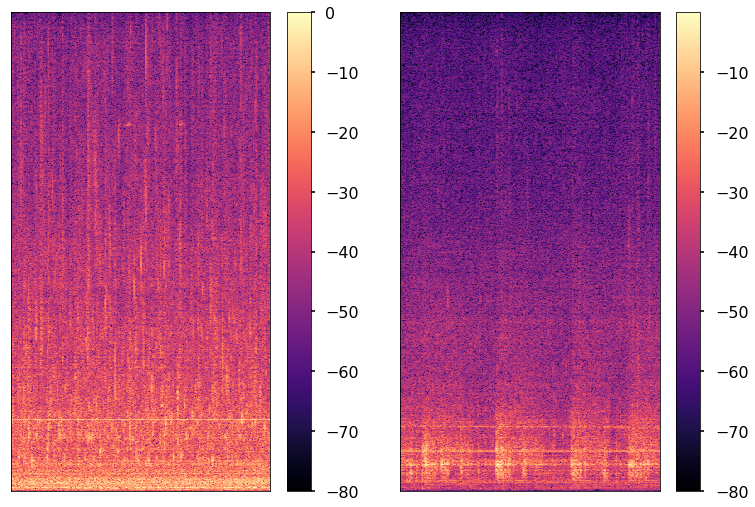

In [27]:
comp_stft(dirs[0])

## Constant-Q transform (CQT)

In [28]:
def comp_cqt(target_dir, file_idx=0, sr=16e3):
    # Compare short time Fourier transform
    
    # get data
    y_norm = get_files(target_dir, file_idx=file_idx)
    y_anorm = get_files(target_dir, file_idx=file_idx, operation='abnormal')
    
    C_norm = librosa.cqt(y_norm, sr=sr)
    C_anorm = librosa.cqt(y_anorm, sr=sr)
    
    plt.subplot(1, 2, 1)
    ax1 = specshow(librosa.amplitude_to_db(np.abs(C_norm), ref=np.max)
                   , cmap=CMAP, x_axis='time', y_axis='cqt_hz')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    ax2 = specshow(librosa.amplitude_to_db(np.abs(C_anorm), ref=np.max)
                   , cmap=CMAP, x_axis='time', y_axis='cqt_hz')
    plt.colorbar()

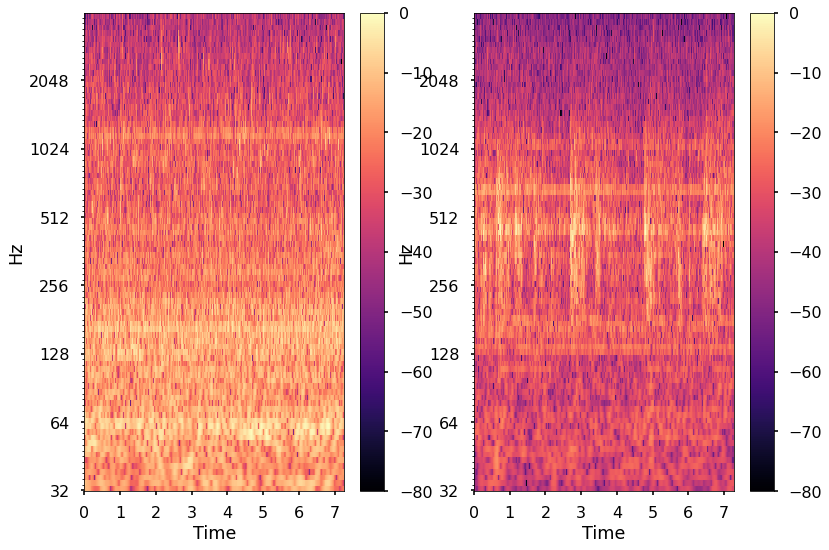

In [25]:
comp_cqt(dirs[0])

## Chroma

In [29]:
def comp_chroma(target_dir, file_idx=0, sr=16e3):
    # Compare short time Fourier transform
    
    # get data
    y_norm = get_files(target_dir, file_idx=file_idx)
    y_anorm = get_files(target_dir, file_idx=file_idx, operation='abnormal')
    
    chroma_norm = librosa.feature.chroma_cqt(y_norm, sr=sr)
    chroma_anorm = librosa.feature.chroma_cqt(y_anorm, sr=sr)
    
    plt.subplot(1, 2, 1)
    ax1 = specshow(chroma_norm, x_axis='time', y_axis='chroma')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    ax2 = specshow(chroma_anorm, x_axis='time', y_axis='chroma')
    plt.colorbar()

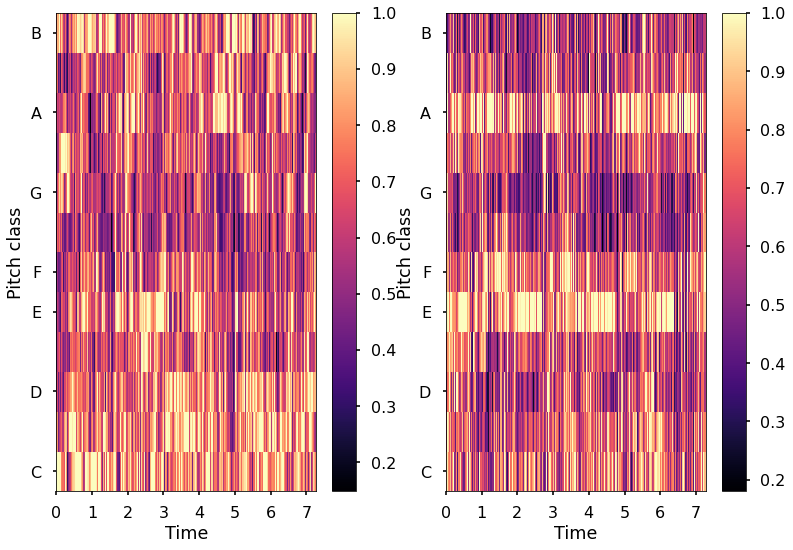

In [30]:
comp_chroma(dirs[0])

In [31]:
def comp_mel(target_dir, file_idx=0, sr=16e3):
    # Compare short time Fourier transform
    
    # get data
    y_norm = get_files(target_dir, file_idx=file_idx)
    y_anorm = get_files(target_dir, file_idx=file_idx, operation='abnormal')
    
    M_norm = librosa.feature.melspectrogram(y_norm, sr=sr)
    M_anorm = librosa.feature.melspectrogram(y_anorm, sr=sr)
    
    plt.subplot(1, 2, 1)
    ax1 = specshow(librosa.amplitude_to_db(M_norm, ref=np.max)
                   , x_axis='time', y_axis='mel')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    ax2 = specshow(librosa.amplitude_to_db(M_anorm, ref=np.max)
                   , x_axis='time', y_axis='mel')
    plt.colorbar()

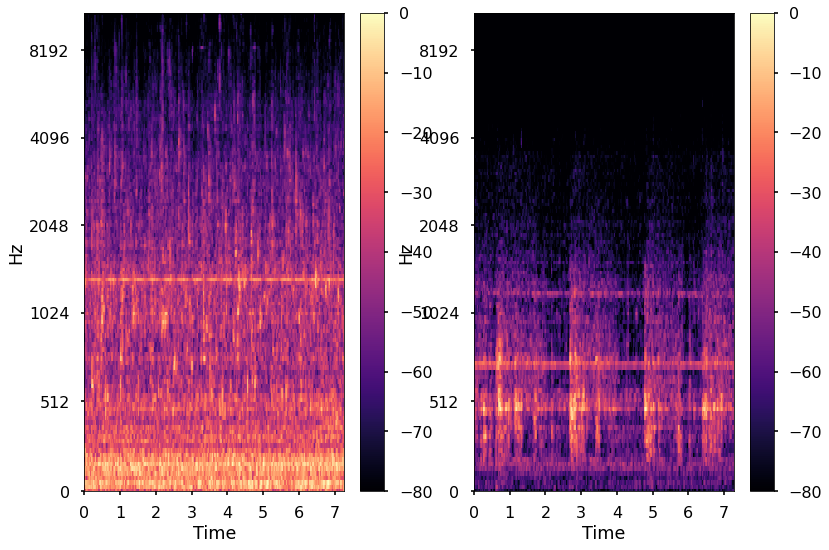

In [32]:
comp_mel(dirs[0])

In [41]:
def comp_mfcc(target_dir, file_idx=0, sr=16e3):
    # Compare short time Fourier transform
    
    # get data
    y_norm = get_files(target_dir, file_idx=file_idx)
    y_anorm = get_files(target_dir, file_idx=file_idx, operation='abnormal')
    
    MFCC_norm = librosa.feature.mfcc(y_norm, sr=sr, n_mfcc=64, dct_type=3)
    MFCC_anorm = librosa.feature.mfcc(y_anorm, sr=sr, n_mfcc=64, dct_type=3)
    
    plt.subplot(1, 2, 1)
    ax1 = specshow(MFCC_norm, cmap='magma', x_axis='time', y_axis='mel')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    ax2 = specshow(MFCC_anorm, cmap='magma', x_axis='time', y_axis='mel')
    plt.colorbar()

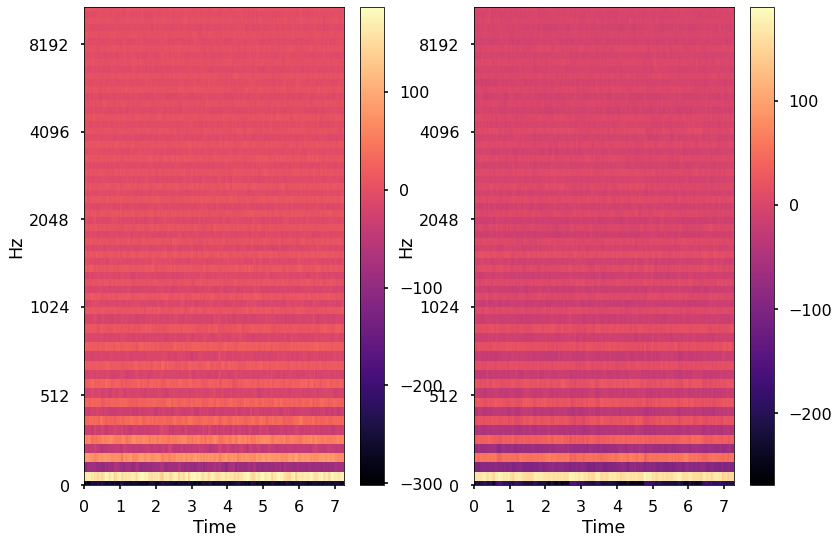

In [42]:
comp_mfcc(dirs[0])

In [43]:
def comp_tonnetz(target_dir, file_idx=0, sr=16e3):
    # Compare short time Fourier transform
    
    # get data
    y_norm = get_files(target_dir, file_idx=file_idx)
    y_anorm = get_files(target_dir, file_idx=file_idx, operation='abnormal')
    
    tn_norm = librosa.feature.tonnetz(y_norm, sr=sr)
    tn_anorm = librosa.feature.tonnetz(y_anorm, sr=sr)
    
    plt.subplot(1, 2, 1)
    ax1 = specshow(tn_norm, cmap=CMAP, x_axis='time', y_axis='tonnetz')
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    ax2 = specshow(tn_norm, cmap=CMAP, x_axis='time', y_axis='tonnetz')
    plt.colorbar()

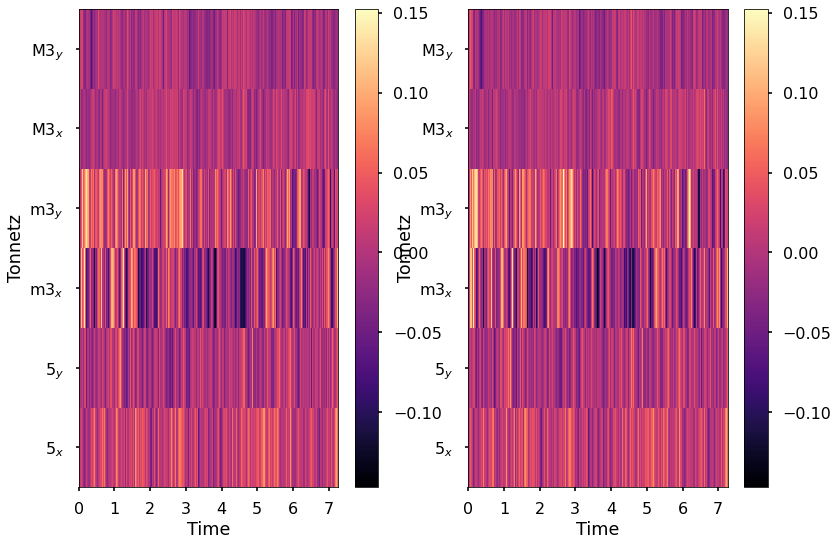

In [44]:
comp_tonnetz(dirs[0])